In [1]:
%cd ..
%cd ..

#note that the goal is to arrive at the MLABpoint-e directory.

/Users/shaurnav/Desktop/MLABpoint-e/point_e
/Users/shaurnav/Desktop/MLABpoint-e


In [2]:
#if you're running in VS Code, ensure that you're using Python 3.9.6 as your python interpreter

!pip3 install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/shaurnav/Desktop/MLABpoint-e
  Cloning https://github.com/openai/CLIP.git to /private/var/folders/vq/hjnyc9414mg86myrkqrl04gh0000gp/T/pip-install-hwk7hn6e/clip_563fb4bdc71742f087a190f2018444d4
  Running command git clone -q https://github.com/openai/CLIP.git /private/var/folders/vq/hjnyc9414mg86myrkqrl04gh0000gp/T/pip-install-hwk7hn6e/clip_563fb4bdc71742f087a190f2018444d4
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Uninstalling point-e-0.0.0:
      Successfully uninstalled point-e-0.0.0
  Running setup.py develop for point-e
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [5]:
# ideally, this would be running on a system 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [6]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [7]:
# Set a prompt to condition on.
prompt = 'Red Motorcycle'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

# Note that this is still relatively slow...

0it [00:00, ?it/s]

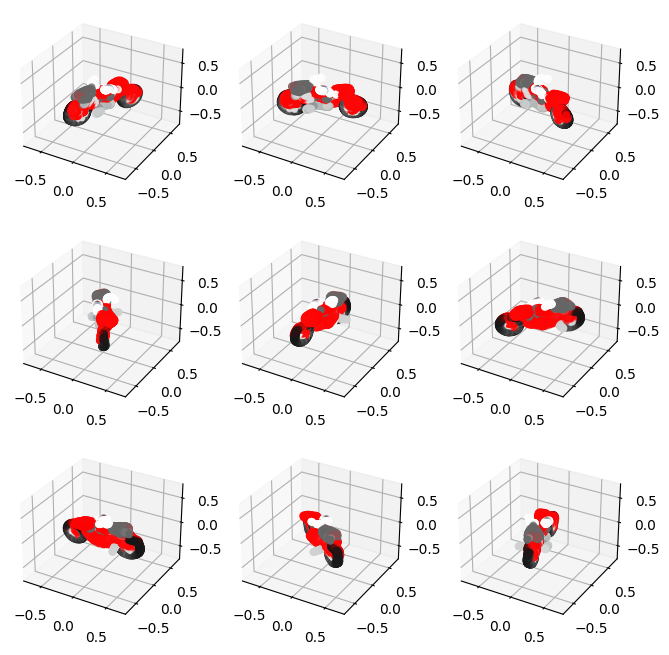

In [12]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
#RUN THIS CELL IF YOU WANT TO SAVE THE POINT CLOUD

pointcloud_filepath = ''
np.savez_compressed('{pointcloud_filepath}.npz', coords=pc.coords, **pc.channels)